In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
from fuzzywuzzy import process, fuzz
from matplotlib import pyplot as plt
import seaborn as sns
import re
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
%matplotlib inline

In [2]:
with open("../data/1000_models.pkl", 'rb') as picklefile:
    models = pkl.load(picklefile)

In [28]:
with open("../data/1000_models_scores.pkl", 'rb') as picklefile:
    scores = pkl.load(picklefile)

In [ ]:
CC = []
l_test = []
l_diff = []
for x in range(1000):
    CC.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].C)
    l_test.append(scores[x]['l2'][1])
    l_diff.append(scores[x]['l2'][1]-scores[x]['l2'][0])
    
sns.boxplot(CC)

In [ ]:
models[x]['l2'].best_estimator_.named_steps['logisticregression'].coef_

In [22]:
uni_public = []
acceptance_rate = []
male = []
caucasian = []
african_american = []
latino = []
asian = []
chi_school = []
chi_home = []
financial_aid = []
median_income = []

for x in range(1000):
    uni_public.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].coef_[0][0])
    acceptance_rate.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].coef_[0][1])
    male.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].coef_[0][2])
    caucasian.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].coef_[0][3])
    african_american.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].coef_[0][4])
    latino.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].coef_[0][5])
    asian.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].coef_[0][6])
    chi_school.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].coef_[0][7])
    chi_home.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].coef_[0][8])
    financial_aid.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].coef_[0][9])
    median_income.append(models[x]['l2'].best_estimator_.named_steps['logisticregression'].coef_[0][10])
    
    
coefficients = pd.DataFrame({#'Public University' : uni_public,
                            #'University Acceptance Rate' : acceptance_rate, 
                            'School in City of Chicago' : chi_school,
                            #'School outside City of Chicago' : np.multiply(-1,chi_school),
                            'Home in City of Chicago' : chi_home,
                            #'Home outside City of Chicago' : np.multiply(-1,chi_home),
                            'CYSO Financial Aid Score' : financial_aid,
                            'Home Zipcode Median Income' : median_income,
                            #'male' : male,
                            'Female' : np.multiply(-1,male),
                            'African American' : african_american,
                            'Caucasian' :  caucasian,
                            'Latinx' : latino,
                            'East Asian' : asian
                            })   
    
    
coefficients.to_csv('../data/model_coefficients.csv')
    
    
    

In [ ]:
type(coefficients.std().values)


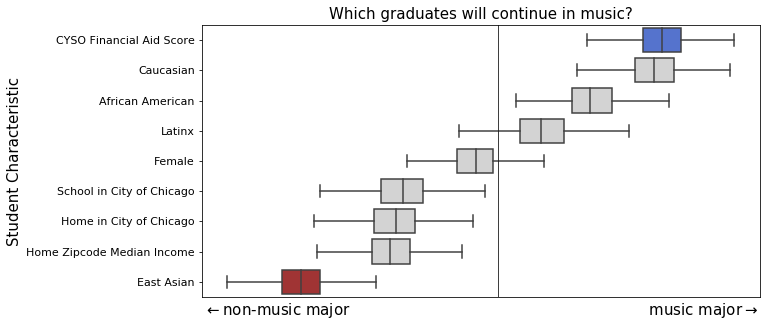

In [26]:

#sns.set(rc={'figure.figsize':(10,5)})
coefficients_plot = coefficients.mean().values
coefficients_std = coefficients.std().values
features_plot = coefficients.columns
coefficients_inds = coefficients_plot.argsort()
sorted_coefficients = coefficients_plot[coefficients_inds[::-1]]
sorted_std = coefficients_std[coefficients_inds[::-1]]
sorted_features = features_plot[coefficients_inds[::-1]]
plot_colors = ['royalblue','lightgrey','lightgrey','lightgrey',
               'lightgrey','lightgrey','lightgrey','lightgrey',
               'firebrick','lightgrey','lightgrey','lightgrey',
               'firebrick','lightgrey']
plt.subplots(figsize=(10,5))
plt.axvline(x=0,c='k',linewidth=0.5)
ax = sns.boxplot(data=coefficients,
                orient = 'h',
                order = sorted_features,
                showfliers=False,
                palette=plot_colors)
plt.axvline(x=0,c='k',linewidth=0.5)
#plt.style.use('ggplot')
ax.set_xlabel(r'$\leftarrow$' + 'non-music major                                               \
                music major'+r'$\rightarrow$',fontsize=15)
ax.set_ylabel('Student Characteristic',fontsize=15)
plt.title('Which graduates will continue in music?',fontsize=15)
plt.tick_params(labelsize=11)
ax.get_xaxis().set_ticks([])
fig = ax.get_figure()
fig.savefig('../plots/coefficients_small.pdf',bbox_inches='tight')

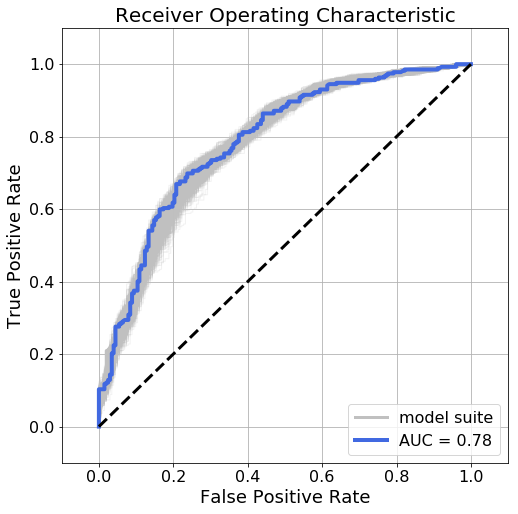

In [35]:
'''
ROC Plot
'''

df = pd.read_csv('../data/fitting_data.csv')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df = df.fillna(0)
y = df.pop('music').values
stratification_columns = df.pop('stratification_column').values
X = df.values

logit_num = 4

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=X[:,9])

datapointers = {
    'l1' : 'logistic',
    'l2' : 'logistic',
    'rf' : 'not_logistic',
    'gb' : 'not_logistic',
    'linsvc' : 'not logistic',
    'rbfsvc' : 'not logistic'
}


# Initialize figure
fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic',fontsize=20)

name = 'l2'

for x in range(1000):
    if datapointers[name] == 'logistic':
        pred = models[x][name].predict_proba(X[:,logit_num:])
    else:
        pred = models[x][name].predict_proba(X)
    pred = [p[1] for p in pred]
    fpr, tpr, thresholds = roc_curve(y, pred)

    
    # Plot ROC curve
    plt.plot(fpr, tpr, c='silver',linewidth=1,alpha=0.2)
    

pred = models[102][name].predict_proba(X[:,logit_num:])
pred = [p[1] for p in pred]
fpr, tpr, thresholds = roc_curve(y, pred)
plt.plot(fpr, tpr, label='model suite', c='silver',linewidth=3)    

plotnum = 104
pred = models[plotnum][name].predict_proba(X[:,logit_num:])
pred = [p[1] for p in pred]
fpr, tpr, thresholds = roc_curve(y, pred)
plt.plot(fpr, tpr, label = 'AUC = {:0.2f}'.format(scores[plotnum]['l2'][1]), c='royalblue',linewidth=4)

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--',linewidth=3)
plt.legend(loc='lower right',fontsize=16)

# Axes limits and labels
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.tick_params(labelsize=16)
plt.grid(True)
plt.show()
fig.savefig('../plots/ROC_suite.pdf',bbox_inches='tight')
fig.savefig('../plots/ROC_suite.png',bbox_inches='tight')

In [ ]:
models[x]['l2'].best_estimator_.named_steps['logisticregression']

In [ ]:
coefficients.boxplot()
#sns.boxplot(asian, hue = ['asian'])

In [ ]:
models[x]['l2'].best_estimator_.named_steps['logisticregression'].C

In [ ]:
scores[x]['l2'][1]

In [ ]:
l_test.append(scores[101]['l2'][0])

In [ ]:
import plotly
print(plotly.__version__)           # version 1.9.4 required